In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.8 MB/s eta 0:00:00


# Import Package

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import statsmodels.api as sm
import time
from statsmodels.stats.diagnostic import het_white,het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import norm, skew, boxcox, probplot, normaltest, jarque_bera #for some statistics
from scipy.special import inv_boxcox

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, RandomizedSearchCV, StratifiedKFold

import xgboost as xgb
import tensorflow as tf
import lightgbm as lgb
from category_encoders.target_encoder import TargetEncoder

import seaborn as sns
import numpy as np
import re

In [ ]:
!pip install ctgan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tens

In [ ]:
# Get dataset from kaggle
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c penyisihan-satria-data-itb-2023
!unzip penyisihan-satria-data-itb-2023.zip
!rm penyisihan-satria-data-itb-2023.zip

  0% 0.00/36.8k [00:00<?, ?B/s]
100% 36.8k/36.8k [00:00<00:00, 84.0MB/s]
Archive:  penyisihan-satria-data-itb-2023.zip
  inflating: sampel submisi.csv      
  inflating: test.csv                
  inflating: train.csv               


# Data Introduction

In [ ]:
# Read Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sampel submisi.csv')

# Cetak Informasi Data
print('Train Information:')
print(train.info())
print('')
print('Test Information:')
print(test.info())

Train Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           600 non-null    int64  
 1   hs           600 non-null    int64  
 2   hst          600 non-null    int64  
 3   hf           600 non-null    int64  
 4   hc           600 non-null    int64  
 5   hy           600 non-null    int64  
 6   hr           600 non-null    int64  
 7   b365h        600 non-null    float64
 8   b365d        600 non-null    float64
 9   bwh          600 non-null    float64
 10  bwd          600 non-null    float64
 11  iwh          600 non-null    float64
 12  iwd          600 non-null    float64
 13  psh          600 non-null    float64
 14  psd          600 non-null    float64
 15  whh          600 non-null    float64
 16  whd          600 non-null    float64
 17  vch          600 non-null    float64
 18  vcd          600 non-null    fl

Tidak ada missing values di kedua data :)

# Analisis Data

## Persebaran Variabel Target

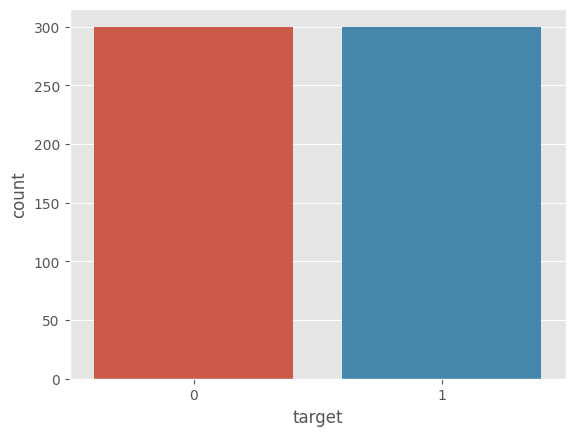

In [ ]:
# Cek Persebaran Variabel Target di data training
sns.countplot(data = train, x = 'target')
plt.show()

Variabel Target Seimbang :)

## Korelasi antar fitur

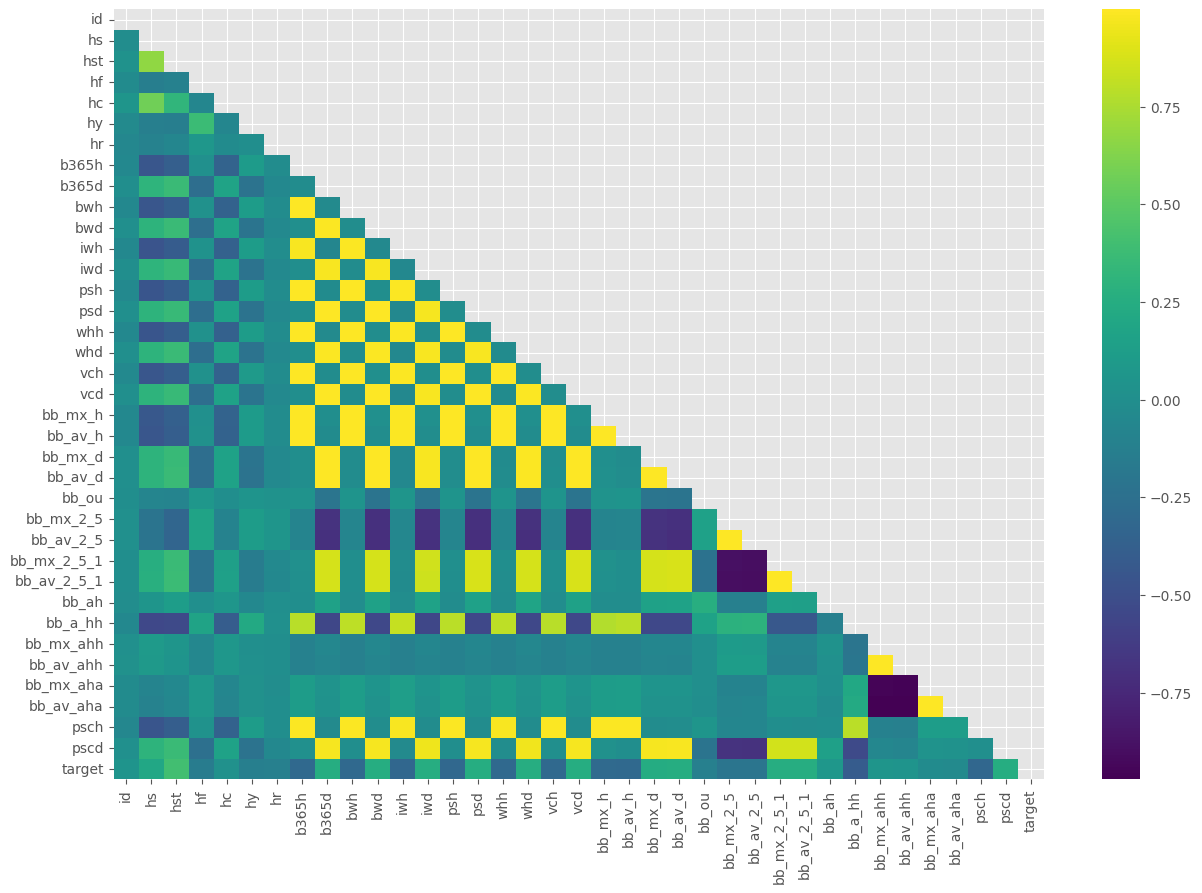

In [ ]:
# Check correlations
corr_mat = train.corr()

# Make triangle mask
tri_mask = np.triu(np.ones_like(corr_mat))

# Visualize
plt.figure(figsize = (15,10))
sns.heatmap(corr_mat, mask = tri_mask, cmap = 'viridis')
plt.grid('off')
plt.show()

# Feature Engineering

## Log Transform Skewed Features

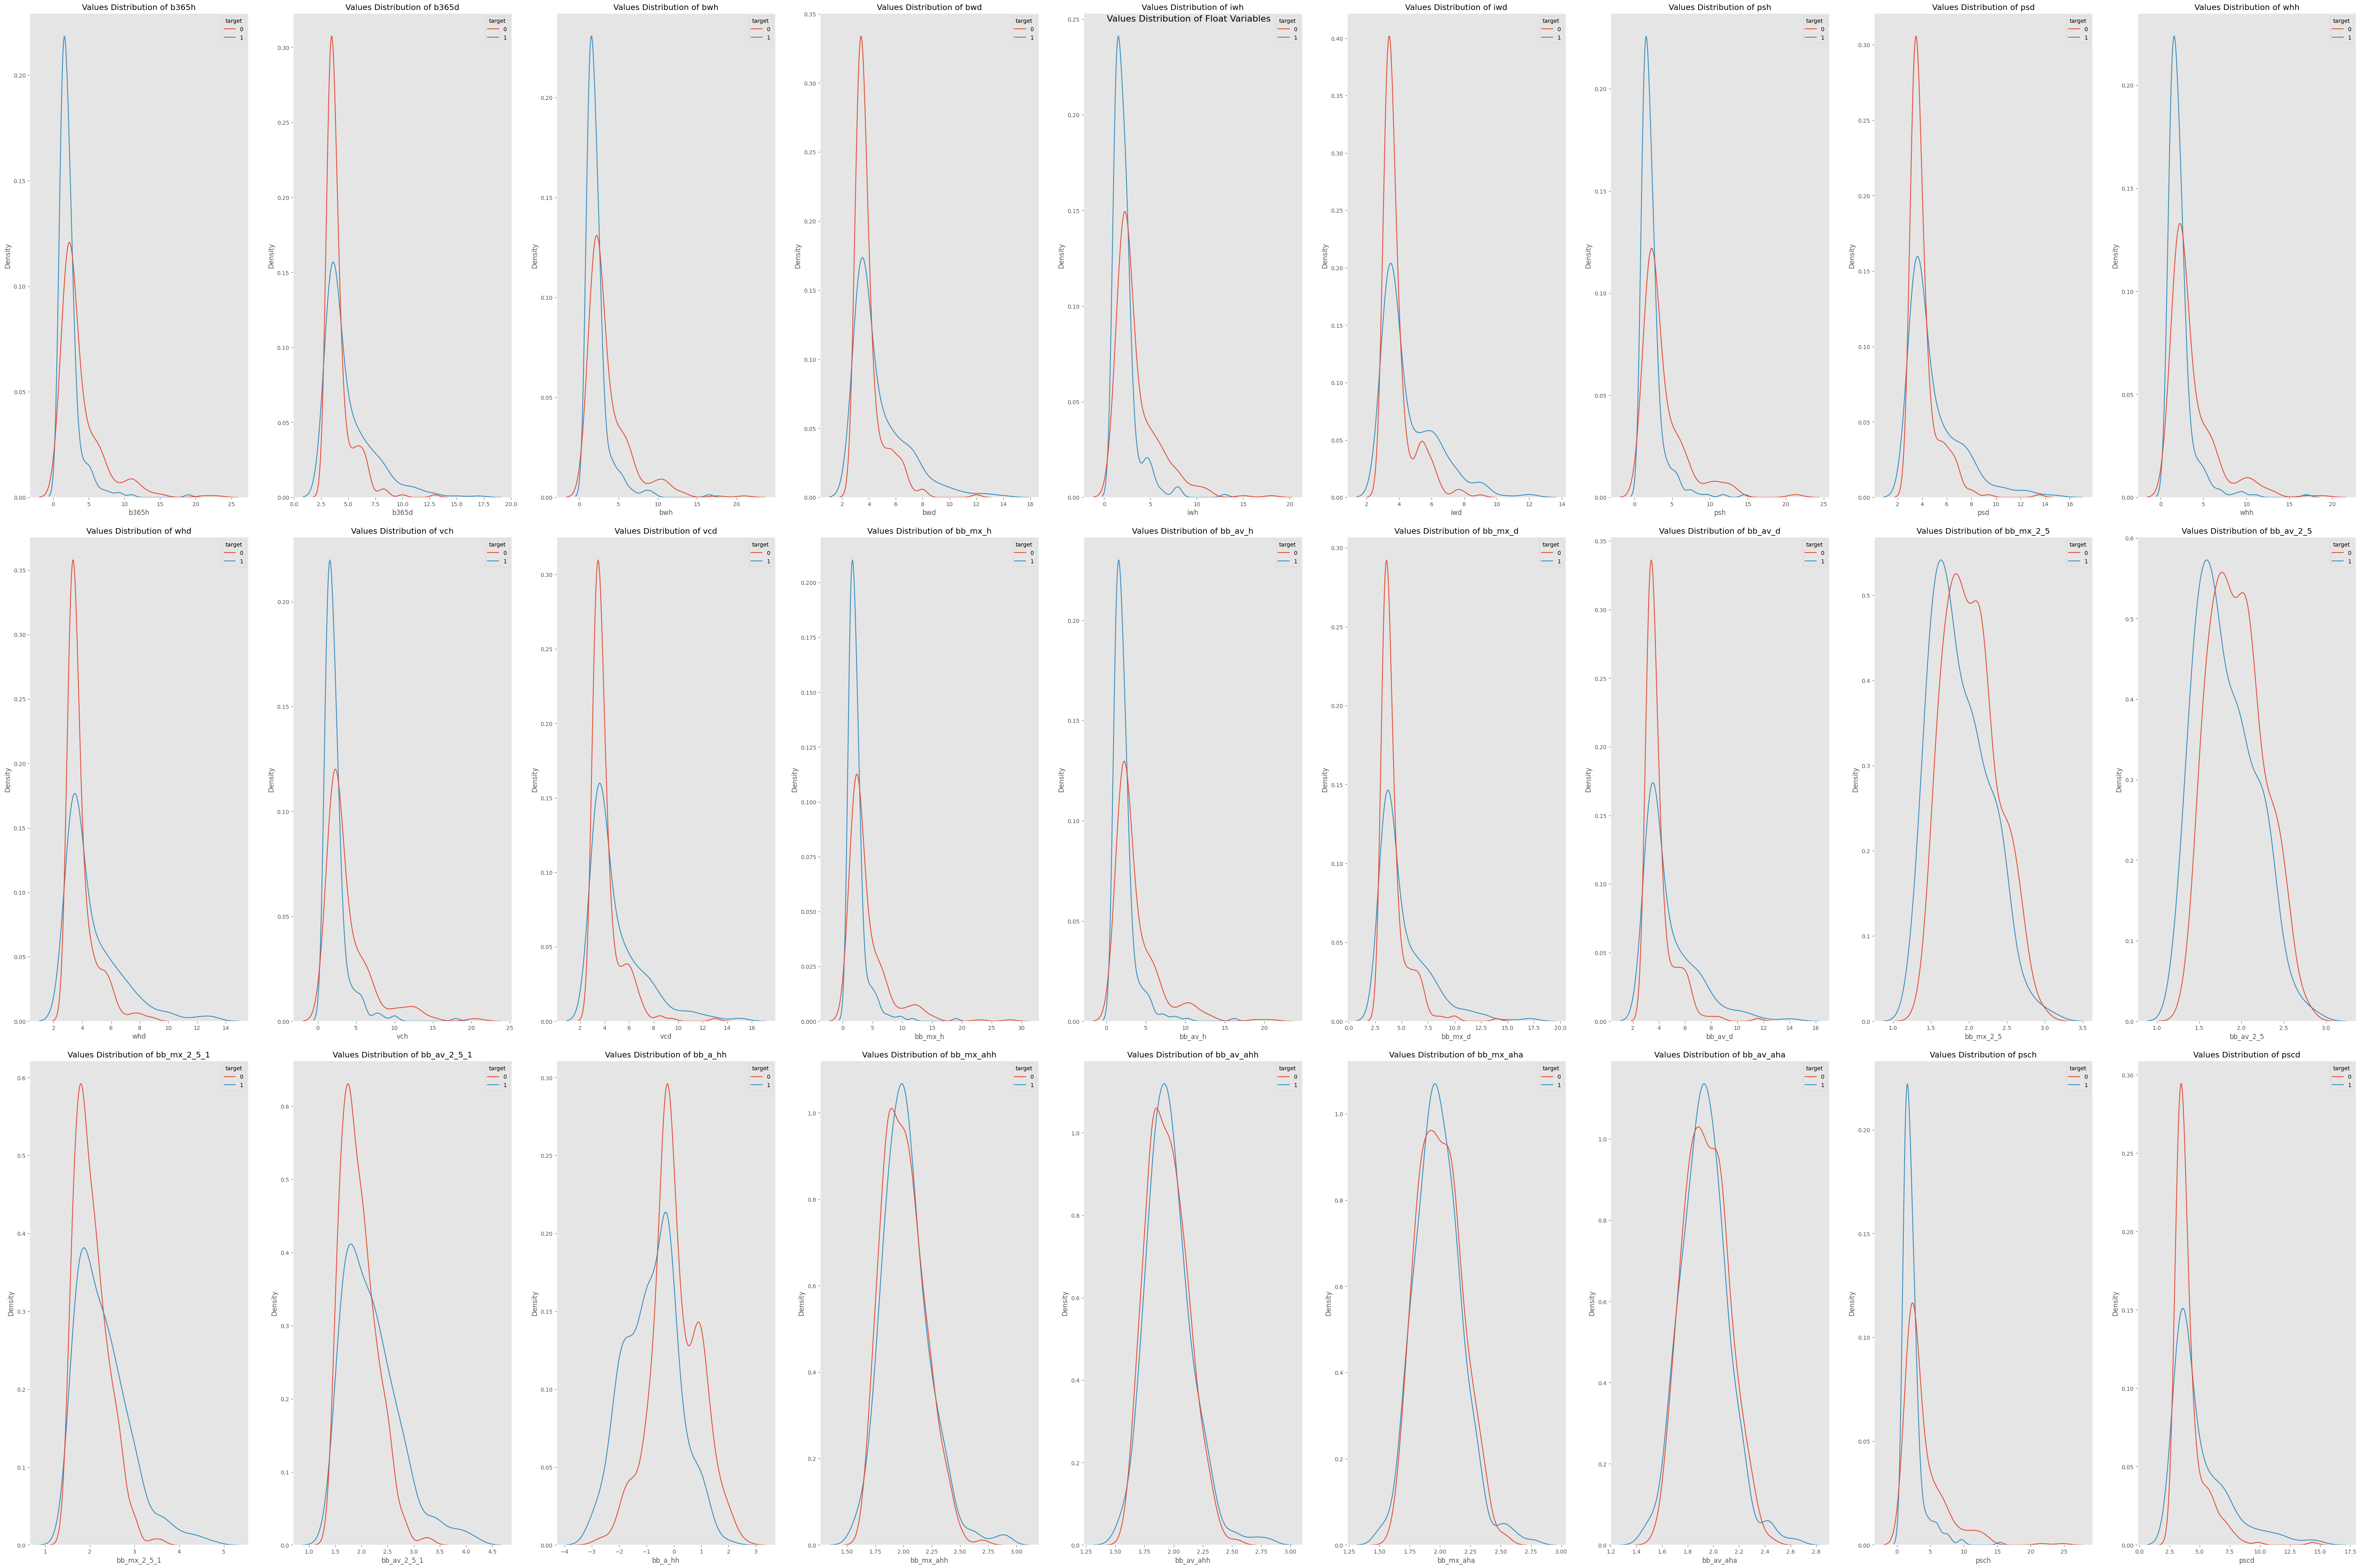

In [ ]:
# Pilih tipe data float dan int
train_float = pd.concat([train.select_dtypes(include = ['float']),
                         train['target']], axis = 1)

# Buat distribusi numeriknya
float_cols = train_float.drop(['target'], axis = 1).columns

# Plot
fig, axes = plt.subplots(3, 9, figsize = (60, 40))
fig.tight_layout(pad = (5.0))

# Plot
fig.suptitle('Values Distribution of Float Variables', fontsize=16)
# Loop
for i, ax in enumerate(axes.flatten()):
  # do stuff to ax
  if i < len(float_cols):
    sns.kdeplot(data = train_float, 
                x = float_cols[i],
                hue = 'target',
                ax = ax)
    ax.set_title(f'Values Distribution of {float_cols[i]}')
    ax.grid(False)

 Beberapa fitur berdistribusi menceng kanan seperti b365h, b365d, bb_mx_2_5, bb_mx_2_5_1, bb_mx_ahh, bb_mx_aha

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           600 non-null    int64  
 1   hs           600 non-null    int64  
 2   hst          600 non-null    int64  
 3   hf           600 non-null    int64  
 4   hc           600 non-null    int64  
 5   hy           600 non-null    int64  
 6   hr           600 non-null    int64  
 7   b365h        600 non-null    float64
 8   b365d        600 non-null    float64
 9   bwh          600 non-null    float64
 10  bwd          600 non-null    float64
 11  iwh          600 non-null    float64
 12  iwd          600 non-null    float64
 13  psh          600 non-null    float64
 14  psd          600 non-null    float64
 15  whh          600 non-null    float64
 16  whd          600 non-null    float64
 17  vch          600 non-null    float64
 18  vcd          600 non-null    float64
 19  bb_mx_h 

In [ ]:
# Set non bb feats
non_bb_feats = [col for col in float_cols if col[:2] != 'bb']

# Transformasi fitur
for feat in non_bb_feats:
  train[feat] = train[feat].apply(lambda value: np.log1p(value))
  test[feat] = test[feat].apply(lambda value: np.log1p(value))

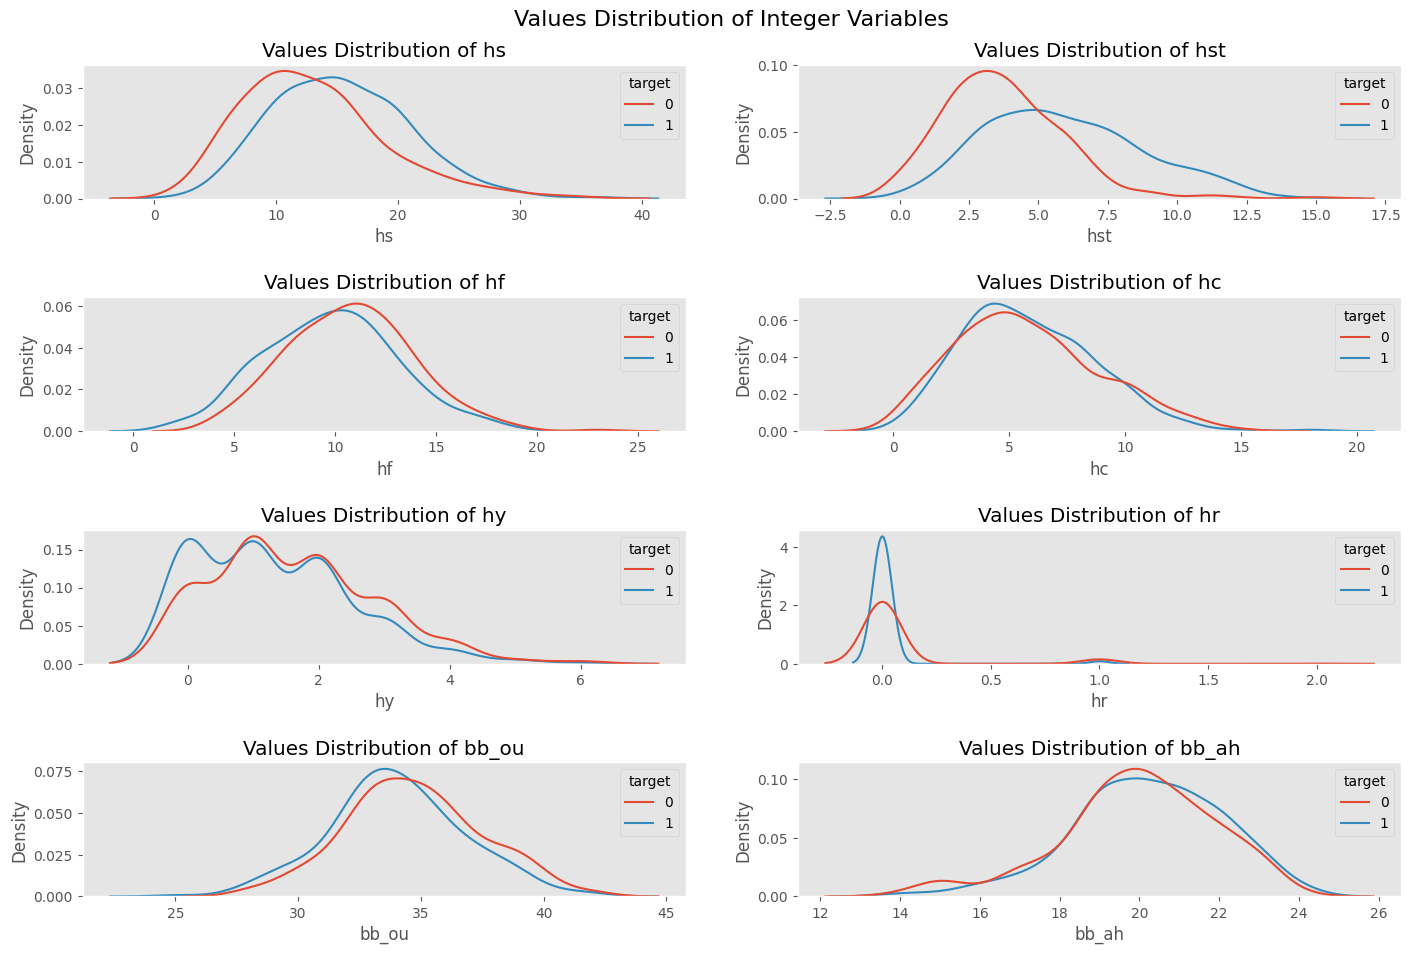

In [ ]:
# Pilih tipe data float dan int
train_int = train.select_dtypes(include = ['int'])

# Buat distribusi numeriknya
int_cols = train_int.drop(['target','id'], axis = 1).columns

# Plot
fig, axes = plt.subplots(4,2, figsize = (15,10))
fig.tight_layout(pad = (5.0))

# Plot
fig.suptitle('Values Distribution of Integer Variables', fontsize=16)
# Loop
for i, ax in enumerate(axes.flatten()):
  # do stuff to ax
  sns.kdeplot(data = train_int, 
               x = int_cols[i],
               hue = 'target',
               ax = ax)
  ax.set_title(f'Values Distribution of {int_cols[i]}')
  ax.grid(False)

Fitur hr terlihat menceng

In [ ]:
# Transformasi fitur
train['hr'] = np.log1p(train['hr'])
test['hr'] = np.log1p(test['hr'])

## Rasio HST/HS 

In [ ]:
# Ratio HST/HS
train['ratio_hst_hs'] = train['hst'].div(train['hs'])
test['ratio_hst_hs'] = test['hst'].div(test['hs'])

## HSM

In [ ]:
# HSM
train['hsm'] = train['hs'] - train['hst']
test['hsm'] = test['hs'] - test['hst']

## Rasio HY/HF & HR/HF

In [ ]:
# Ratio HY/HF
train['ratio_hy_hf'] = train['hy'].div(train['hf'])
test['ratio_hy_hf'] = test['hy'].div(test['hf'])

# Ratio HR/HF
train['ratio_hr_hf'] = train['hr'].div(train['hf'])
test['ratio_hr_hf'] = test['hr'].div(test['hf'])

# Ratio hyhr hf
train['ratio_hyhr_hf'] = (train['hr']+train['hy']).div(train['hf'])
test['ratio_hyhr_hf'] = (test['hr']+train['hy']).div(test['hf'])

## Clusterisasi berdasarkan odds

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 42 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             600 non-null    int64  
 1   hs             600 non-null    int64  
 2   hst            600 non-null    int64  
 3   hf             600 non-null    int64  
 4   hc             600 non-null    int64  
 5   hy             600 non-null    int64  
 6   hr             600 non-null    float64
 7   b365h          600 non-null    float64
 8   b365d          600 non-null    float64
 9   bwh            600 non-null    float64
 10  bwd            600 non-null    float64
 11  iwh            600 non-null    float64
 12  iwd            600 non-null    float64
 13  psh            600 non-null    float64
 14  psd            600 non-null    float64
 15  whh            600 non-null    float64
 16  whd            600 non-null    float64
 17  vch            600 non-null    float64
 18  vcd       

In [ ]:
# Odd features
home_win_odd_feats = ['bwh', 'b365h', 'iwh', 'psh', 'whh', 'vch', 'psch']
home_draw_odd_feats = ['bwd', 'b365d', 'iwd', 'psd', 'whd', 'vcd', 'pscd']

# Set bb feats
bb_feats = [col for col in float_cols if col[:2] == 'bb']

### Win Odds

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

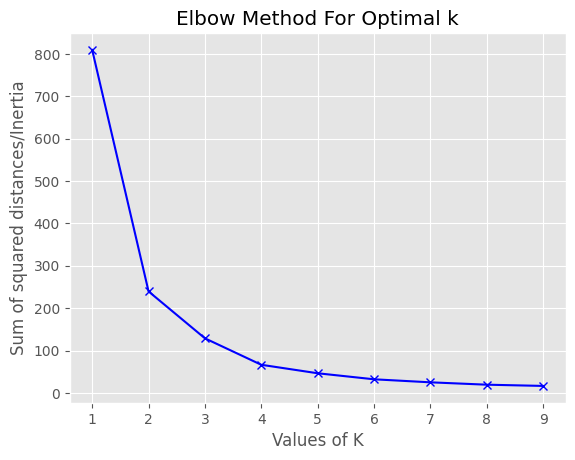

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(train[home_win_odd_feats])
  Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

Pilih k = 4

In [ ]:
# Inisialisasi Model
KMeans_4 = KMeans(n_clusters = 4, random_state=0, n_init="auto")

# Fit & Predict
KMeans_4.fit(train[home_win_odd_feats])
train['win_odds_cluster'] = KMeans_4.predict(train[home_win_odd_feats])
test['win_odds_cluster'] = KMeans_4.predict(test[home_win_odd_feats])

# See the results
train['win_odds_cluster']

0      0
1      1
2      1
3      0
4      0
      ..
595    1
596    1
597    0
598    1
599    1
Name: win_odds_cluster, Length: 600, dtype: int32

### Draw Odds

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

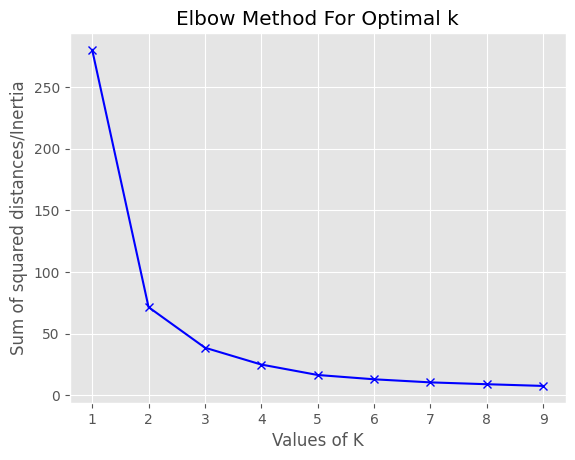

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(train[home_draw_odd_feats])
  Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

Pilih k = 4

In [ ]:
# Inisialisasi Model
KMeans_4 = KMeans(n_clusters = 4, random_state=0, n_init="auto")

# Fit & Predict
KMeans_4.fit(train[home_draw_odd_feats])
train['draw_odds_cluster'] = KMeans_4.predict(train[home_draw_odd_feats])
test['draw_odds_cluster'] = KMeans_4.predict(test[home_draw_odd_feats])

# See the results
train['draw_odds_cluster']

0      0
1      1
2      1
3      0
4      0
      ..
595    2
596    3
597    0
598    1
599    2
Name: draw_odds_cluster, Length: 600, dtype: int32

### Odds bb

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

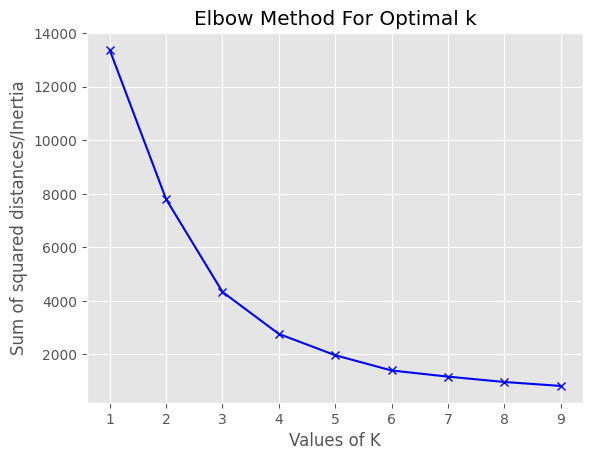

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(train[bb_feats])
  Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

Pilih k = 6

In [ ]:
# Inisialisasi Model
KMeans_6 = KMeans(n_clusters = 6, random_state=0, n_init="auto")

# Fit & Predict
KMeans_6.fit(train[bb_feats])
train['bb_odds_cluster'] = KMeans_6.predict(train[bb_feats])
test['bb_odds_cluster'] = KMeans_6.predict(test[bb_feats])

# See the results
train['bb_odds_cluster']

0      5
1      4
2      4
3      5
4      5
      ..
595    5
596    4
597    5
598    4
599    5
Name: bb_odds_cluster, Length: 600, dtype: int32

## Bet yang mencapai maksimum odds

### Win Odds

In [ ]:
# Get argmax train & test
argmax_train = train[home_win_odd_feats].values.argmax(axis = 1)
argmax_test = test[home_win_odd_feats].values.argmax(axis = 1)
argmin_train = train[home_win_odd_feats].values.argmin(axis = 1)
argmin_test = test[home_win_odd_feats].values.argmin(axis = 1)

train['max_win_bet_org'] = [home_win_odd_feats[i] for i in argmax_train]
test['max_win_bet_org'] = [home_win_odd_feats[i] for i in argmax_test]
train['min_win_bet_org'] = [home_win_odd_feats[i] for i in argmin_train]
test['min_win_bet_org'] = [home_win_odd_feats[i] for i in argmin_test]

### Draw Odds

In [ ]:
# Get argmax train & test
argmax_train = train[home_draw_odd_feats].values.argmax(axis = 1)
argmax_test = test[home_draw_odd_feats].values.argmax(axis = 1)
argmin_train = train[home_draw_odd_feats].values.argmin(axis = 1)
argmin_test = test[home_draw_odd_feats].values.argmin(axis = 1)

train['max_draw_bet_org'] = [home_draw_odd_feats[i] for i in argmax_train]
test['max_draw_bet_org'] = [home_draw_odd_feats[i] for i in argmax_test]
train['min_draw_bet_org'] = [home_draw_odd_feats[i] for i in argmin_train]
test['min_draw_bet_org'] = [home_draw_odd_feats[i] for i in argmin_test]

## Buat fitur statistik dari win odds baru

### Win Odds

In [ ]:
train['mean_win_odds'] =  train[home_win_odd_feats].mean(axis = 1)
train['median_win_odds'] =  train[home_win_odd_feats].median(axis = 1)
train['max_win_odds'] =  train[home_win_odd_feats].max(axis = 1)
train['min_win_odds'] =  train[home_win_odd_feats].min(axis = 1)
train['std_win_bets'] = train[home_win_odd_feats].std(axis = 1)

test['mean_win_odds'] =  test[home_win_odd_feats].mean(axis = 1)
test['median_win_odds'] =  test[home_win_odd_feats].median(axis = 1)
test['max_win_odds'] =  test[home_win_odd_feats].max(axis = 1)
test['min_win_odds'] =  test[home_win_odd_feats].min(axis = 1)
test['std_win_bets'] = test[home_win_odd_feats].std(axis = 1)

In [ ]:
def calculate_loss_odds(win_odds, draw_odds):
    loss_odds = 1 / (1 / win_odds + 1 / draw_odds)
    return loss_odds

for i in range(len(home_win_odd_feats)):
  train[f'{home_win_odd_feats[i][:2]}_loss_odds'] = calculate_loss_odds(train[home_win_odd_feats[i]], 
                                                                    train[home_draw_odd_feats[i]])
  test[f'{home_win_odd_feats[i][:2]}_loss_odds'] = calculate_loss_odds(test[home_win_odd_feats[i]], 
                                                                    test[home_draw_odd_feats[i]])

## Drop Fitur Multikolinear

In [ ]:
# Drop Highly Correlated Features
# select upper traingle of correlation matrix
#upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

# Find index of columns with correlation greater than 0.95
#to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# drop the columns
#train.drop(to_drop, axis= 1, inplace = True)
#test.drop(to_drop, axis = 1, inplace = True)

# Prediction

In [ ]:
# Split data
X_train = train.drop(['target','id'], axis = 1)
y_train = train['target']

# Encode using target encoder
te = TargetEncoder(cols = ['max_win_bet_org','min_win_bet_org','max_draw_bet_org','min_draw_bet_org'],
                   smoothing = 10)

# Fit
te.fit(X_train, y_train)

# Transform
X_train_te = te.transform(X_train)
X_test = te.transform(test.drop(['id'], axis = 1))

In [ ]:
def cross_validate_pred(model, model_params = 'Default', train_feats = X_train_te, target = y_train):
  # Tracking progress
  folds = []
  model_list = []
  parameter = []
  exec_time = []
  train_accuracy_scores = []
  test_accuracy_scores = []

  print(str(model).upper())
  print('--------------------')
  print(f'Parameter: {model_params}')

  # Initiate SkF and f1_array
  skf = StratifiedKFold(n_splits=10)

  # Cross validation
  for i, (train_index, test_index) in enumerate(skf.split(train_feats, target)):
    # Calculate the starting time
    start_time = time.time()

    # Append the name model and params
    model_list.append(str(model))
    parameter.append(model_params)

    # Print index
    print(f"Fold {i+1}:")
    folds.append(i+1)

    # Filter the index
    X_train_subset = train_feats.iloc[train_index, :]
    X_test_subset = train_feats.iloc[test_index, :]
    y_train_subset = target[train_index]
    y_test_subset = target[test_index]

    # Fit the model
    model.fit(X_train_subset, y_train_subset)

    # Predict
    y_pred_train = model.predict(X_train_subset)
    y_pred_test = model.predict(X_test_subset)

    # Calculate the f1 score
    train_acc = accuracy_score(y_train_subset, y_pred_train)
    test_acc = accuracy_score(y_test_subset, y_pred_test)
    print('Training Accuracy Score:', train_acc)
    print('Test Accuracy Score:', test_acc)
    train_accuracy_scores.append(train_acc)
    test_accuracy_scores.append(test_acc)
    
    # Calculate the end time
    end_time = time.time() - start_time
    exec_time.append(end_time)
    print('')

  # Cetak rerata dan mediannya
  print('Rerata Accuracy Training CV:', np.mean(train_accuracy_scores))
  print('Rerata Accuracy Test CV:', np.mean(test_accuracy_scores))

  # Buat DataFrame
  dict_df = {'Model': model_list,
             'Parameters': parameter,
             'Fold': folds,
             'Training Time': exec_time,
             'Train Accuracy': train_accuracy_scores,
             'Test Accuracy': test_accuracy_scores}

  # Combine dataframe
  df = pd.DataFrame(dict_df)

  # Return df
  return df

## Linear Models

### Logistic Regression

In [ ]:
# Logreg
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression())

# Cross Validate
logreg_df = cross_validate_pred(logreg_pipeline, model_params = 'Default', train_feats = X_train_te, target = y_train)

PIPELINE(STEPS=[('STANDARDSCALER', STANDARDSCALER()),
                ('LOGISTICREGRESSION', LOGISTICREGRESSION())])
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 0.7518518518518519
Test Accuracy Score: 0.6666666666666666

Fold 2:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training Accuracy Score: 0.7555555555555555
Test Accuracy Score: 0.6333333333333333

Fold 3:
Training Accuracy Score: 0.75
Test Accuracy Score: 0.7166666666666667

Fold 4:
Training Accuracy Score: 0.737037037037037
Test Accuracy Score: 0.75

Fold 5:
Training Accuracy Score: 0.7314814814814815
Test Accuracy Score: 0.7166666666666667

Fold 6:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy Score: 0.7388888888888889
Test Accuracy Score: 0.8

Fold 7:
Training Accuracy Score: 0.75
Test Accuracy Score: 0.7

Fold 8:
Training Accuracy Score: 0.7351851851851852
Test Accuracy Score: 0.8166666666666667

Fold 9:
Training Accuracy Score: 0.7555555555555555
Test Accuracy Score: 0.6666666666666666

Fold 10:
Training Accuracy Score: 0.7481481481481481
Test Accuracy Score: 0.6666666666666666

Rerata Accuracy Training CV: 0.7453703703703705
Rerata Accuracy Test CV: 0.7133333333333334


In [ ]:
# Tune Model
logreg = LogisticRegression(max_iter = 1000)

# Tune Model
grid_logreg = {'C':[0.001*10**i for i in range(7)]}

# Optimisasi
skf = StratifiedKFold(n_splits=10)
logreg_cv = RandomizedSearchCV(logreg, grid_logreg, scoring = 'accuracy', cv = skf)
logreg_cv.fit(X_train_te, y_train)

logreg_best_params = logreg_cv.best_params_
print('Best Params:', logreg_best_params)
logreg_best_score = logreg_cv.best_score_
print('Best Score:', logreg_best_score)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown i

Best Params: {'C': 100.0}
Best Score: 0.7266666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Logreg
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', 
                                                                     C = 100))

# Cross Validate
tuned_logreg_df = cross_validate_pred(logreg_pipeline, model_params = 'Tuned', train_feats = X_train_te, target = y_train)

PIPELINE(STEPS=[('STANDARDSCALER', STANDARDSCALER()),
                ('LOGISTICREGRESSION', LOGISTICREGRESSION(C=100))])
--------------------
Parameter: Tuned
Fold 1:
Training Accuracy Score: 0.7648148148148148
Test Accuracy Score: 0.65

Fold 2:
Training Accuracy Score: 0.7722222222222223
Test Accuracy Score: 0.6333333333333333

Fold 3:
Training Accuracy Score: 0.7611111111111111
Test Accuracy Score: 0.6333333333333333

Fold 4:
Training Accuracy Score: 0.7555555555555555
Test Accuracy Score: 0.7666666666666667

Fold 5:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training Accuracy Score: 0.7518518518518519
Test Accuracy Score: 0.7166666666666667

Fold 6:
Training Accuracy Score: 0.737037037037037
Test Accuracy Score: 0.8

Fold 7:
Training Accuracy Score: 0.762962962962963
Test Accuracy Score: 0.6666666666666666

Fold 8:
Training Accuracy Score: 0.7444444444444445
Test Accuracy Score: 0.7666666666666667

Fold 9:
Training Accuracy Score: 0.7648148148148148
Test Accuracy Score: 0.65

Fold 10:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training Accuracy Score: 0.7481481481481481
Test Accuracy Score: 0.6833333333333333

Rerata Accuracy Training CV: 0.7562962962962965
Rerata Accuracy Test CV: 0.6966666666666667


### Ridge Classifier

In [ ]:
# Logreg
ridge_pipeline = make_pipeline(StandardScaler(), RidgeClassifier())

# Cross Validate
ridge_df = cross_validate_pred(ridge_pipeline, model_params = 'Default', train_feats = X_train_te, target = y_train)

PIPELINE(STEPS=[('STANDARDSCALER', STANDARDSCALER()),
                ('RIDGECLASSIFIER', RIDGECLASSIFIER())])
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 0.7611111111111111
Test Accuracy Score: 0.6833333333333333

Fold 2:
Training Accuracy Score: 0.7592592592592593
Test Accuracy Score: 0.6666666666666666

Fold 3:
Training Accuracy Score: 0.7555555555555555
Test Accuracy Score: 0.6666666666666666

Fold 4:
Training Accuracy Score: 0.7444444444444445
Test Accuracy Score: 0.7666666666666667

Fold 5:
Training Accuracy Score: 0.7333333333333333
Test Accuracy Score: 0.7

Fold 6:
Training Accuracy Score: 0.7425925925925926
Test Accuracy Score: 0.8166666666666667

Fold 7:
Training Accuracy Score: 0.7518518518518519
Test Accuracy Score: 0.6833333333333333

Fold 8:
Training Accuracy Score: 0.7425925925925926
Test Accuracy Score: 0.7833333333333333

Fold 9:
Training Accuracy Score: 0.7462962962962963
Test Accuracy Score: 0.7166666666666667

Fold 10:
Training Accuracy 

In [ ]:
# Tune Model
ridge = RidgeClassifier()

# Tune Model
grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10, 100],
               'fit_intercept': [True, False]}

# Optimisasi
skf = StratifiedKFold(n_splits=10)
ridge_cv = RandomizedSearchCV(ridge, grid_ridge, scoring = 'accuracy', cv = skf)
ridge_cv.fit(X_train_te, y_train)

ridge_best_params = ridge_cv.best_params_
print('Best Params:', ridge_best_params)
ridge_best_score = ridge_cv.best_score_
print('Best Score:', ridge_best_score)

Best Params: {'fit_intercept': True, 'alpha': 0.1}
Best Score: 0.7183333333333334


In [ ]:
# Logreg
ridge_pipeline = make_pipeline(StandardScaler(), RidgeClassifier(fit_intercept = True,
                                                                 alpha = 0.1))

# Cross Validate
tuned_ridge_df = cross_validate_pred(ridge_pipeline, 
                                     model_params = 'Tuned', 
                                     train_feats = X_train_te, 
                                     target = y_train)

PIPELINE(STEPS=[('STANDARDSCALER', STANDARDSCALER()),
                ('RIDGECLASSIFIER', RIDGECLASSIFIER(ALPHA=0.1))])
--------------------
Parameter: Tuned
Fold 1:
Training Accuracy Score: 0.7666666666666667
Test Accuracy Score: 0.6666666666666666

Fold 2:
Training Accuracy Score: 0.762962962962963
Test Accuracy Score: 0.6666666666666666

Fold 3:
Training Accuracy Score: 0.7574074074074074
Test Accuracy Score: 0.6666666666666666

Fold 4:
Training Accuracy Score: 0.75
Test Accuracy Score: 0.75

Fold 5:
Training Accuracy Score: 0.7425925925925926
Test Accuracy Score: 0.7166666666666667

Fold 6:
Training Accuracy Score: 0.7481481481481481
Test Accuracy Score: 0.8

Fold 7:
Training Accuracy Score: 0.7592592592592593
Test Accuracy Score: 0.6833333333333333

Fold 8:
Training Accuracy Score: 0.7444444444444445
Test Accuracy Score: 0.7666666666666667

Fold 9:
Training Accuracy Score: 0.7666666666666667
Test Accuracy Score: 0.6833333333333333

Fold 10:
Training Accuracy Score: 0.7555555555555

### SGD Classifier

In [ ]:
# SGD
sgd_pipeline = make_pipeline(StandardScaler(), SGDClassifier())

# Cross Validate
sgd_df = cross_validate_pred(sgd_pipeline, 
                             model_params = 'Default', 
                             train_feats = X_train_te, 
                             target = y_train)

PIPELINE(STEPS=[('STANDARDSCALER', STANDARDSCALER()),
                ('SGDCLASSIFIER', SGDCLASSIFIER())])
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 0.7074074074074074
Test Accuracy Score: 0.5166666666666667

Fold 2:
Training Accuracy Score: 0.7148148148148148
Test Accuracy Score: 0.6166666666666667

Fold 3:
Training Accuracy Score: 0.7222222222222222
Test Accuracy Score: 0.7166666666666667

Fold 4:
Training Accuracy Score: 0.7518518518518519
Test Accuracy Score: 0.7333333333333333

Fold 5:
Training Accuracy Score: 0.6851851851851852
Test Accuracy Score: 0.6333333333333333

Fold 6:
Training Accuracy Score: 0.7444444444444445
Test Accuracy Score: 0.6833333333333333

Fold 7:
Training Accuracy Score: 0.7055555555555556
Test Accuracy Score: 0.6666666666666666

Fold 8:
Training Accuracy Score: 0.5685185185185185
Test Accuracy Score: 0.5666666666666667

Fold 9:
Training Accuracy Score: 0.7111111111111111
Test Accuracy Score: 0.75

Fold 10:
Training Accuracy Sco

In [ ]:
# Tune Model
sgdc = SGDClassifier()

# Tune Model
grid_sgdc = {'loss': ['hinge','log_loss','log','modified_huber','squared_hinge','perceptron',
                      'squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive'],
             'penalty': ['l1','l2','elasticnet', None],
             'alpha': [0.01, 0.1, 1.0, 10, 100]}

# Optimisasi
skf = StratifiedKFold(n_splits=10)
sgdc_cv = RandomizedSearchCV(sgdc, grid_sgdc, scoring = 'accuracy', cv = skf)
sgdc_cv.fit(X_train_linear, y_train)

sgdc_best_params = sgdc_cv.best_params_
print('Best Params:', sgdc_best_params)
sgdc_best_score = sgdc_cv.best_score_
print('Best Score:', sgdc_best_score)

Best Params: {'penalty': None, 'loss': 'perceptron', 'alpha': 0.1}
Best Score: 0.6916666666666667


In [ ]:
# SGD
sgd_pipeline = make_pipeline(StandardScaler(), SGDClassifier(**sgdc_best_params))

# Cross Validate
tuned_sgd_df = cross_validate_pred(sgd_pipeline, 
                                   model_params = 'Tuned', 
                                   train_feats = X_train_linear, 
                                   target = y_train)

PIPELINE(STEPS=[('STANDARDSCALER', STANDARDSCALER()),
                ('SGDCLASSIFIER',
                 SGDCLASSIFIER(ALPHA=0.1, LOSS='PERCEPTRON', PENALTY=NONE))])
--------------------
Parameter: Tuned
Fold 1:
Training Accuracy Score: 0.7277777777777777
Test Accuracy Score: 0.6333333333333333

Fold 2:
Training Accuracy Score: 0.7148148148148148
Test Accuracy Score: 0.5833333333333334

Fold 3:
Training Accuracy Score: 0.737037037037037
Test Accuracy Score: 0.65

Fold 4:
Training Accuracy Score: 0.7018518518518518
Test Accuracy Score: 0.7166666666666667

Fold 5:
Training Accuracy Score: 0.7222222222222222
Test Accuracy Score: 0.7

Fold 6:
Training Accuracy Score: 0.6851851851851852
Test Accuracy Score: 0.7333333333333333

Fold 7:
Training Accuracy Score: 0.6981481481481482
Test Accuracy Score: 0.6666666666666666

Fold 8:
Training Accuracy Score: 0.6944444444444444
Test Accuracy Score: 0.75

Fold 9:
Training Accuracy Score: 0.7148148148148148
Test Accuracy Score: 0.65

Fold 10:
Training

### Perceptron

In [ ]:
# perceptron
percept_pipeline = make_pipeline(StandardScaler(), Perceptron())

# Cross Validate
percept_df = cross_validate_pred(percept_pipeline, 
                                 model_params = 'Tuned', 
                                 train_feats = X_train, 
                                 target = y_train)

PIPELINE(STEPS=[('STANDARDSCALER', STANDARDSCALER()),
                ('PERCEPTRON', PERCEPTRON())])
--------------------
Parameter: Tuned
Fold 1:
Training Accuracy Score: 0.5777777777777777
Test Accuracy Score: 0.5166666666666667

Fold 2:
Training Accuracy Score: 0.6425925925925926
Test Accuracy Score: 0.6

Fold 3:
Training Accuracy Score: 0.6666666666666666
Test Accuracy Score: 0.8166666666666667

Fold 4:
Training Accuracy Score: 0.7203703703703703
Test Accuracy Score: 0.6666666666666666

Fold 5:
Training Accuracy Score: 0.6962962962962963
Test Accuracy Score: 0.7

Fold 6:
Training Accuracy Score: 0.7037037037037037
Test Accuracy Score: 0.7666666666666667

Fold 7:
Training Accuracy Score: 0.6425925925925926
Test Accuracy Score: 0.55

Fold 8:
Training Accuracy Score: 0.6314814814814815
Test Accuracy Score: 0.7333333333333333

Fold 9:
Training Accuracy Score: 0.5555555555555556
Test Accuracy Score: 0.5166666666666667

Fold 10:
Training Accuracy Score: 0.6555555555555556
Test Accuracy S

## Tree Models

### Decision Tree Classifier

In [ ]:
# Cross Validate
dt_df = cross_validate_pred(DecisionTreeClassifier(), 
                            model_params = 'Default', 
                            train_feats = X_train_te, 
                            target = y_train)

DECISIONTREECLASSIFIER()
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.5833333333333334

Fold 2:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.55

Fold 3:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.7833333333333333

Fold 4:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6

Fold 5:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6166666666666667

Fold 6:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6166666666666667

Fold 7:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.5833333333333334

Fold 8:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6333333333333333

Fold 9:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6333333333333333

Fold 10:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6333333333333333

Rerata Accuracy Training CV: 1.0
Rerata Accuracy Test CV: 0.6233333333333333


In [ ]:
# Tune Model
dt = DecisionTreeClassifier(random_state = 111)

# Tune Model
grid_dt = {'criterion':['gini','entropy','log_loss'],
           'splitter':['best','random'],
           'max_depth':[None, 5, 8, 15, 25, 30],
           'min_samples_split':[2, 5, 10, 15, 100],
           'min_samples_leaf':[1, 2, 5, 10],
           'max_features':['log2', 'sqrt', None]}

# Optimisasi
dt_cv = RandomizedSearchCV(dt, grid_dt, scoring = 'accuracy', cv = skf)
dt_cv.fit(X_train_te, y_train)

dt_best_params = dt_cv.best_params_
print('Best Params:', dt_best_params)
dt_best_score = dt_cv.best_score_
print('Best Score:', dt_best_score)

Best Params: {'splitter': 'best', 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'log_loss'}
Best Score: 0.675


In [ ]:
# Cross Validate
tuned_dt_df = cross_validate_pred(DecisionTreeClassifier(**dt_best_params), 
                            model_params = 'Tuned', 
                            train_feats = X_train_te, 
                            target = y_train)

DECISIONTREECLASSIFIER(CRITERION='LOG_LOSS', MAX_DEPTH=8, MAX_FEATURES='SQRT',
                       MIN_SAMPLES_LEAF=2, MIN_SAMPLES_SPLIT=100)
--------------------
Parameter: Tuned
Fold 1:
Training Accuracy Score: 0.7277777777777777
Test Accuracy Score: 0.6333333333333333

Fold 2:
Training Accuracy Score: 0.7240740740740741
Test Accuracy Score: 0.6333333333333333

Fold 3:
Training Accuracy Score: 0.7222222222222222
Test Accuracy Score: 0.6833333333333333

Fold 4:
Training Accuracy Score: 0.7407407407407407
Test Accuracy Score: 0.6333333333333333

Fold 5:
Training Accuracy Score: 0.737037037037037
Test Accuracy Score: 0.6666666666666666

Fold 6:
Training Accuracy Score: 0.7018518518518518
Test Accuracy Score: 0.7333333333333333

Fold 7:
Training Accuracy Score: 0.7351851851851852
Test Accuracy Score: 0.65

Fold 8:
Training Accuracy Score: 0.7111111111111111
Test Accuracy Score: 0.7333333333333333

Fold 9:
Training Accuracy Score: 0.7111111111111111
Test Accuracy Score: 0.7

Fold 10:
T

### Random Forest 

In [ ]:
# Cross Validate
rf_df = cross_validate_pred(RandomForestClassifier(), 
                            model_params = 'Default', 
                            train_feats = X_train_te, 
                            target = y_train)

RANDOMFORESTCLASSIFIER()
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.65

Fold 2:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6333333333333333

Fold 3:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.7166666666666667

Fold 4:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6833333333333333

Fold 5:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.7333333333333333

Fold 6:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.7

Fold 7:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6333333333333333

Fold 8:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.7833333333333333

Fold 9:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6666666666666666

Fold 10:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6666666666666666

Rerata Accuracy Training CV: 1.0
Rerata Accuracy Test CV: 0.6866666666666668


In [ ]:
# Tune Model
rf = RandomForestClassifier()

# Tune Model
grid_rf = {'n_estimators': [120, 300, 500, 800, 1200],
           'max_depth': [5, 8, 15, 25, 30, None],
           'min_samples_split': [2, 5, 10, 15, 100],
           'min_samples_leaf': [1, 2, 5, 10]}

# Optimisasi
rf_cv = RandomizedSearchCV(rf, grid_rf, scoring = 'accuracy', cv = skf)
rf_cv.fit(X_train_te, y_train)

rf_best_params = rf_cv.best_params_
print('Best Params:', rf_best_params)
rf_best_score = rf_cv.best_score_
print('Best Score:', rf_best_score)

Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Best Score: 0.7


In [ ]:
# Cross Validate
tuned_rf_df = cross_validate_pred(RandomForestClassifier(**rf_best_params), 
                            model_params = 'Default', 
                            train_feats = X_train, 
                            target = y_train)

RANDOMFORESTCLASSIFIER(MAX_DEPTH=30, MIN_SAMPLES_SPLIT=5, N_ESTIMATORS=1200)
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 0.9962962962962963
Test Accuracy Score: 0.65

Fold 2:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.6333333333333333

Fold 3:
Training Accuracy Score: 0.9981481481481481
Test Accuracy Score: 0.7666666666666667

Fold 4:
Training Accuracy Score: 0.9981481481481481
Test Accuracy Score: 0.7333333333333333

Fold 5:
Training Accuracy Score: 0.9981481481481481
Test Accuracy Score: 0.7

Fold 6:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.7333333333333333

Fold 7:
Training Accuracy Score: 0.9981481481481481
Test Accuracy Score: 0.6333333333333333

Fold 8:
Training Accuracy Score: 0.9962962962962963
Test Accuracy Score: 0.7833333333333333

Fold 9:
Training Accuracy Score: 0.9981481481481481
Test Accuracy Score: 0.7666666666666667

Fold 10:
Training Accuracy Score: 0.9981481481481481
Test Accuracy Score: 0.6666666666666666

Rerata Accu

### XGB

In [ ]:
# Cross Validate
xgb_df = cross_validate_pred(xgb.XGBClassifier(), 
                            model_params = 'Default', 
                            train_feats = X_train, 
                            target = y_train)

XGBCLASSIFIER(BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
              COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
              COLSAMPLE_BYTREE=NONE, EARLY_STOPPING_ROUNDS=NONE,
              ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
              GAMMA=NONE, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
              INTERACTION_CONSTRAINTS=NONE, LEARNING_RATE=NONE, MAX_BIN=NONE,
              MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
              MAX_DELTA_STEP=NONE, MAX_DEPTH=NONE, MAX_LEAVES=NONE,
              MIN_CHILD_WEIGHT=NONE, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
              N_ESTIMATORS=100, N_JOBS=NONE, NUM_PARALLEL_TREE=NONE,
              PREDICTOR=NONE, RANDOM_STATE=NONE, ...)
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.64

Fold 2:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.72

Fold 3:
Training Accuracy Score: 1.0
Test Accuracy Score: 0.66

Fold 4:
Training

In [ ]:
# Tune Model
xgbc = xgb.XGBClassifier()

grid_XGB = {'learning_rate' : [0.01, 0.015, 0.025, 0.05, 0.1],
            'n_estimators' : [100, 300, 500],
            'gamma' : [0.05, 0.075, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
            'max_depth' : [3, 5, 7, 9, 12, 15, 17, 25],
            'min_child_weight' : [1,3,5,7],
            'lambda' : [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 1],
            'subsample' : [0.6, 0.7, 0.8, 0.9, 1],
            'colsample_bytree' : [0.6,0.7,0.8,0.9,1],
            'alpha' : [0, 0.1, 0.5, 1]}

xgb_cv = RandomizedSearchCV(xgbc, grid_XGB, scoring = 'accuracy', cv = skf)
xgb_cv.fit(X_train, y_train)

xgbr_best_params = xgb_cv.best_params_
print('Best Params:', xgbr_best_params)
xgbr_best_score = xgb_cv.best_score_
print('Best Score:', xgbr_best_score)

Best Params: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.015, 'lambda': 0.09, 'gamma': 0.9, 'colsample_bytree': 0.8, 'alpha': 0}
Best Score: 0.7083333333333334


In [ ]:
# Cross Validate
xgb_df = cross_validate_pred(xgb.XGBClassifier(**xgbr_best_params), 
                            model_params = 'Default', 
                            train_feats = X_train_tree, 
                            target = y_train)

XGBCLASSIFIER(ALPHA=1, BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
              COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
              COLSAMPLE_BYTREE=0.7, EARLY_STOPPING_ROUNDS=NONE,
              ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
              GAMMA=0.9, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
              INTERACTION_CONSTRAINTS=NONE, LAMBDA=0.01, LEARNING_RATE=0.01,
              MAX_BIN=NONE, MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
              MAX_DELTA_STEP=NONE, MAX_DEPTH=7, MAX_LEAVES=NONE,
              MIN_CHILD_WEIGHT=1, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
              N_ESTIMATORS=300, N_JOBS=NONE, NUM_PARALLEL_TREE=NONE, ...)
--------------------
Parameter: Default
Fold 1:
Training Accuracy Score: 0.9407407407407408
Test Accuracy Score: 0.6666666666666666

Fold 2:
Training Accuracy Score: 0.9277777777777778
Test Accuracy Score: 0.7333333333333333

Fold 3:
Training Accuracy Score: 0.9351851851851852
Test 

## Neural Network 

In [ ]:
# Define your model architecture
tf.random.set_seed(123)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_dim=(X_train.shape[1])),
    tf.keras.layers.Dense(8, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(8, activation='relu'),
    # # # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0025),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 16)                944       
                                                                 
 dense_37 (Dense)            (None, 8)                 136       
                                                                 
 dense_38 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train_te

,hs,hst,hf,hc,hy,hr,b365h,b365d,bwh,bwd,...,median_win_odds,max_win_odds,min_win_odds,std_win_bets,bw_loss_odds,b3_loss_odds,iw_loss_odds,ps_loss_odds,wh_loss_odds,vc_loss_odds
0,23,6,7,10,2,0.0,1.081805,1.504077,1.068153,1.504077,...,1.075002,1.085189,1.047319,0.013243,0.624588,0.629231,0.623410,0.625986,0.617407,0.629231
1,21,5,5,8,1,0.0,0.824175,2.014903,0.815365,1.945910,...,0.828552,0.862890,0.815365,0.015526,0.574599,0.584920,0.574215,0.586657,0.581117,0.581117
2,17,6,8,7,1,0.0,0.824175,2.014903,0.824175,1.909543,...,0.824175,0.845868,0.810930,0.011270,0.575699,0.584920,0.582594,0.575951,0.572393,0.581117
3,26,11,12,6,1,0.0,1.064711,1.566530,1.040277,1.558145,...,1.064711,1.124930,1.040277,0.025778,0.623802,0.633884,0.623410,0.645995,0.633720,0.632507
4,20,6,11,3,3,0.0,1.252763,1.435085,1.252763,1.410987,...,1.252763,1.316408,1.252763,0.023792,0.663588,0.668870,0.663588,0.681029,0.663588,0.668870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,16,5,7,5,0,0.0,0.936093,1.648659,0.943906,1.609438,...,0.936093,0.947789,0.916291,0.010901,0.594968,0.597078,0.591372,0.597514,0.591855,0.594968
596,21,12,5,7,1,0.0,0.770108,2.251292,0.770108,2.140066,...,0.774727,0.797507,0.765468,0.010517,0.566317,0.573820,0.571360,0.578885,0.564438,0.571286
597,15,8,12,5,3,0.0,1.064711,1.504077,1.064711,1.481605,...,1.064711,1.081805,1.047319,0.010238,0.619515,0.623410,0.627267,0.622603,0.612363,0.617407
598,23,6,10,12,3,0.0,0.810930,2.014903,0.810930,1.909543,...,0.810930,0.815365,0.806476,0.002566,0.569205,0.578217,0.572393,0.578204,0.572393,0.578217


In [ ]:
# Tracking progress
folds = []
model_list = []
exec_time = []
train_accuracy_scores = []
test_accuracy_scores = []

model_str = 'Neural Network'

print(str(model_str).upper())
print('--------------------')

# Initiate SkF and f1_array
skf = StratifiedKFold(n_splits=10)

# Cross validation
for i, (train_index, test_index) in enumerate(skf.split(X_train_te, y_train)):
  # Calculate the starting time
  start_time = time.time()

  # Append the name model and params
  model_list.append(model_str)

  # Print index
  print(f"Fold {i+1}:")
  folds.append(i+1)

  # Filter the index
  X_train_subset = X_train_te.iloc[train_index, :]
  X_test_subset = X_train_te.iloc[test_index, :]
  y_train_subset = y_train[train_index]
  y_test_subset = y_train[test_index]

  # Fit the model
  model.fit(X_train_subset, 
            y_train_subset, 
            epochs=200, 
            batch_size=128, 
            validation_data=(X_test_subset, y_test_subset),
            verbose = 0)

  # Predict
  y_pred_train = model.predict(X_train_subset)
  y_pred_test = model.predict(X_test_subset)

  # Calculate the f1 score
  loss_train, accuracy_train = model.evaluate(X_train_subset, y_train_subset, batch_size=128)
  loss_test, accuracy_test = model.evaluate(X_test_subset, y_test_subset, batch_size=128)
  print(f"Train loss: {loss_train}")
  print(f"Train accuracy: {accuracy_train}")
  print(f"Validation loss: {loss_test}")
  print(f"Validation accuracy: {accuracy_test}")
  train_accuracy_scores.append(accuracy_train)
  test_accuracy_scores.append(accuracy_test)
    
  # Calculate the end time
  end_time = time.time() - start_time
  exec_time.append(end_time)
  print('')

# Cetak rerata dan mediannya
print('Rerata Accuracy Training CV:', np.mean(train_accuracy_scores))
print('Rerata Accuracy Test CV:', np.mean(test_accuracy_scores))

# Buat DataFrame
dict_df = {'Model': model_list,
            'Fold': folds,
            'Training Time': exec_time,
            'Train Accuracy': train_accuracy_scores,
            'Test Accuracy': test_accuracy_scores}

# Combine dataframe
nn_df = pd.DataFrame(dict_df)

NEURAL NETWORK
--------------------
Fold 1:
1/1 [==============================] - 0s 26ms/step - loss: 0.7288 - accuracy: 0.6167
Train loss: 0.49162665009498596
Train accuracy: 0.7462962865829468
Validation loss: 0.7287576198577881
Validation accuracy: 0.6166666746139526

Fold 2:
1/1 [==============================] - 0s 26ms/step - loss: 0.6041 - accuracy: 0.6833
Train loss: 0.45114436745643616
Train accuracy: 0.770370364189148
Validation loss: 0.6040584444999695
Validation accuracy: 0.6833333373069763

Fold 3:
1/1 [==============================] - 0s 27ms/step - loss: 0.4567 - accuracy: 0.7333
Train loss: 0.44536343216896057
Train accuracy: 0.7833333611488342
Validation loss: 0.4567057192325592
Validation accuracy: 0.7333333492279053

Fold 4:
1/1 [==============================] - 0s 25ms/step - loss: 0.5121 - accuracy: 0.7333
Train loss: 0.40006154775619507
Train accuracy: 0.8148148059844971
Validation loss: 0.5120775103569031
Validation accuracy: 0.7333333492279053

Fold 5:
1/1 [

In [ ]:
# Train the model
model.fit(X_train_te, y_train, epochs=200, batch_size=128)

# Predict
y_pred = model.predict(X_test)

Epoch 1/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3341 - accuracy: 0.8317
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3221 - accuracy: 0.8433
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3218 - accuracy: 0.8483
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3179 - accuracy: 0.8567
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3155 - accuracy: 0.8517
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3069 - accuracy: 0.8633
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3046 - accuracy: 0.8583
Epoch 8/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3039 - accuracy: 0.8550
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3046 - accuracy: 0.8583
Epoch 10/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3031 - accuracy: 0.8550
Epoch 11/200
5/5 [===========

In [ ]:
# Map to 1 and 0
binary_predictions = (y_pred > 0.5).astype(int)
binary_predictions

array([[1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]])
[100]
0s


In [ ]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = binary_predictions
submission.set_index('id', inplace = True)

In [ ]:
submission.head(20)

,target
id,
1,1
2,1
3,0
4,1
5,0
6,1
7,1
8,1
9,1


In [ ]:
submission.to_csv('submission_nn_2.csv')